In [66]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

words = open('names.txt', 'r').read().splitlines()


In [67]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [68]:
# hyper parameters
import random
block_size = 3 # context length: how many previous tokens will be used to predict the next
emb_dim = 10  # dimension of embedding vector
h_size = 300  # size of hidden layer
epochs = 200000
batch_size = 64


def build_dataset(words):
    ins, outs = [], []

    for w in words:
        # for w in words[:5]:
        # print(w)
        context = [0] * block_size  # init empty context for first word
        for ch in (w+'.'):
            ix = stoi[ch]
            ins.append(context)
            outs.append(ix)
            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]  # move forward in context

    ins = torch.tensor(ins)
    outs = torch.tensor(outs)
    print(ins.shape, outs.shape)
    return ins, outs


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

in_train, out_train = build_dataset(words[:n1])
in_val, out_val = build_dataset(words[n1:n2])
in_test, out_test = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [69]:
# two dimensional embedding for each 27 characters
C = torch.randn((len(itos), emb_dim))
# hidden layer
# 100 neurons in the hidden layer, each with an input of (3 context len * 2-dim vector)
W1 = torch.randn(((block_size*emb_dim), h_size))* (5/3) / ((block_size*emb_dim)**0.5) # kaiming init, to fix saturating tanh to extreme values
# b1 = torch.randn(h_size) 						* 0.01 # biases are subtracted during batch normalization, therefore useless 
# output layer
W2 = torch.randn((h_size, len(itos))) 			* 0.01
b2 = torch.randn(len(itos)) 					* 0

# we only want hpreact to be perfectly gaussian at initialization
# but as we train we want it to modified however the backprop sees fit
# without bngain and bnbias, hpreact is forced to be gaussian at every iteration
# bngain and bnbias are therefore used as learnable parameters so that they can modify the hpreact gaussianization as demanded by the backprop 
bn_gain = torch.ones((1, h_size)) 	
bn_bias = torch.zeros((1, h_size))
bnmean_running = torch.zeros((1, h_size))
bnstd_running = torch.ones((1, h_size))

# parameters = [C, W1, b1, W2, b2, bn_bias, bn_gain]
parameters = [C, W1, W2, b2, bn_bias, bn_gain]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)


18297

In [85]:
# before introducing batch normalization, calculating logits from batches of examples was a deterministic process

# but batch normalization now mixes and blends (so to speak) all inputs in the randomly sampled batch

# and therefore this process applies a kind of padding and regularization to unit examples which prevents overfitting of the data

# although batch normalization, in first glance, seems to mess with the data, in the end, it is still a good thing

# since batch normalization mixes examples in the batch, people had tried alternatives to batch normalization

# that does not mixes examples in the batch, such as group normalization etc.

# but the regularization and gaussianization of batch normalization stabilizes the training so well that it is still the most used

In [86]:
# we've seen that batch norm mixes examples in the batch

# but we may want to test one single example after training for evaluation purpose 

# while the NN expects a batch and calculates the mean and std deviation of the batch

# we can fix this by calculating the mean and std deviation of the whole training set <s>once after training is complete</s> by keeping a running mean and std and updating it with each batch

In [70]:
# decreasing learning rate
lre = torch.linspace(-1, -3, epochs)
lrs = 10**lre
lri = []
lossi = []
stepi = []

for i in range(epochs):
	# minibatch
	ix = torch.randint(0, in_train.shape[0], (batch_size,))
	in_b, out_b = in_train[ix], out_train[ix]

	# forward pass
	emb = C[in_b]
	emb_cat = emb.view(-1, (block_size*emb_dim))
	# Linear layer
	h_preact = emb_cat @ W1 #+ b1 	# hidden layer pre-activation (b1 is superseded and made obsolete by bn_bias)
	# Bath norm layer
	bnmeani = h_preact.mean(0, keepdim=True)
	bnstdi = h_preact.std(0, keepdim=True)
	h_preact = bn_gain * (h_preact - bnmeani) / bnstdi + bn_bias # batch norm to make inputs gaussian (this prevents tanh saturation or inactivity due to extreme or zero values)
	# Non-linear layer (tanh)
	h = torch.tanh(h_preact) 		# hidden layer
	logits = h @ W2 + b2 			# output layer
	loss = F.cross_entropy(logits, out_b)
	# print(loss.item())

	with torch.no_grad():
		bnmean_running = bnmean_running * 0.999 + bnmeani * 0.001
		bnstd_running = bnstd_running * 0.999 + bnstdi * 0.001

	# backward pass
	for p in parameters:
		p.grad = None
	loss.backward()

	# update
	# lr = lrs[i] 						# gradual decrease
	lr = 0.1 if i < 100000 else 0.01 	# two-step decrease
	for p in parameters:
		p.data += -lr * p.grad

	# track stats
	if i % 10000 == 0:
		print(f'{i:7d}/{epochs:7d}: {loss.item():.4f} with lr: {lr:.4f}')
	lossi.append(loss.log10().item())
	stepi.append(i)
	# break

      0/ 200000: 3.2973 with lr: 0.1000
  10000/ 200000: 2.3214 with lr: 0.1000
  20000/ 200000: 1.9242 with lr: 0.1000
  30000/ 200000: 2.0995 with lr: 0.1000
  40000/ 200000: 2.2334 with lr: 0.1000
  50000/ 200000: 2.1266 with lr: 0.1000
  60000/ 200000: 2.2291 with lr: 0.1000
  70000/ 200000: 2.1570 with lr: 0.1000
  80000/ 200000: 2.2692 with lr: 0.1000
  90000/ 200000: 2.1281 with lr: 0.1000
 100000/ 200000: 2.2608 with lr: 0.0100
 110000/ 200000: 2.2767 with lr: 0.0100
 120000/ 200000: 2.1569 with lr: 0.0100
 130000/ 200000: 2.0965 with lr: 0.0100
 140000/ 200000: 2.0517 with lr: 0.0100
 150000/ 200000: 1.9309 with lr: 0.0100
 160000/ 200000: 1.7310 with lr: 0.0100
 170000/ 200000: 2.1168 with lr: 0.0100
 180000/ 200000: 2.0989 with lr: 0.0100
 190000/ 200000: 2.0813 with lr: 0.0100


In [ ]:
# expected NLL loss when all 27 characters have the same probability
# or what we should expect at initialization
-(torch.tensor(1/27.0)).log()

tensor(3.2958)

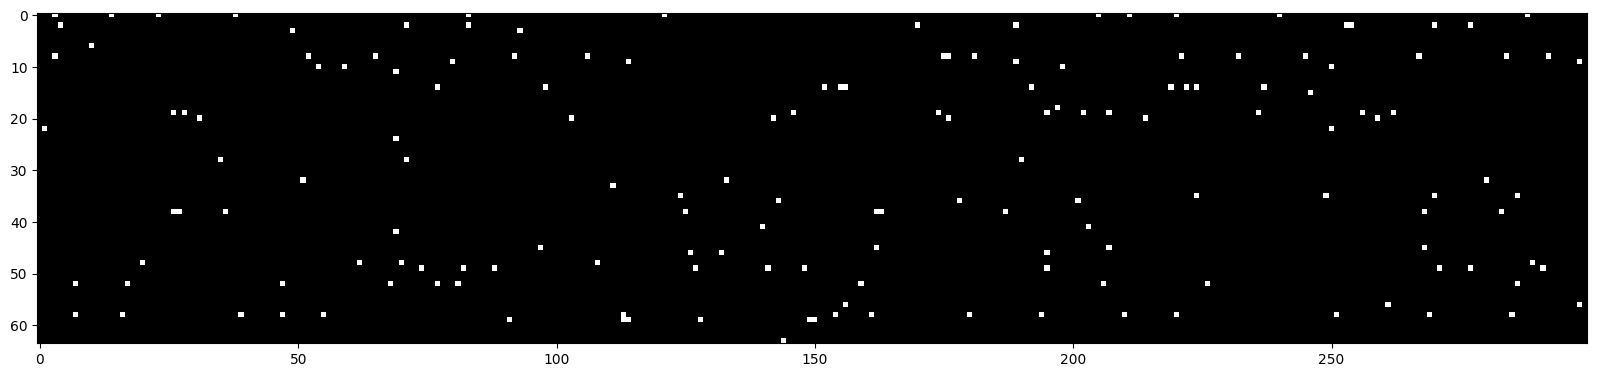

In [ ]:
# if most neurons in the hidden layer has activations that falls on the flat regions of the tanh graph
# therefore that neuron does not learn and is useless
# if a column here is all white, it means all inputs are at the extreme and that neuron is dead
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

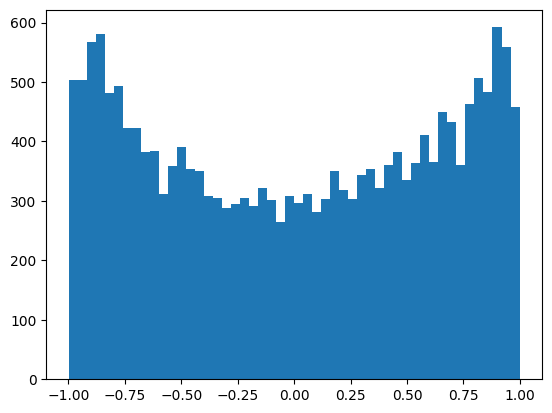

In [ ]:
plt.hist(h.view(-1).tolist(), 50);

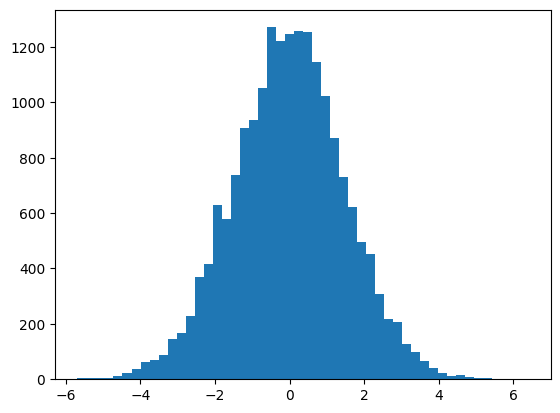

In [ ]:
plt.hist((emb_cat @ W1 + b1).view(-1).tolist(), 50);

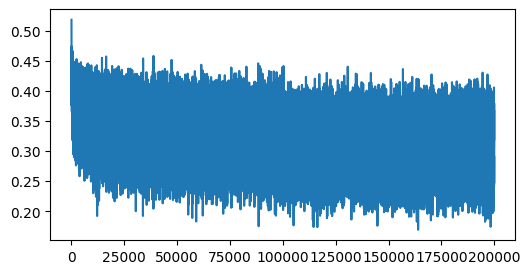

In [87]:
plt.figure(figsize=(6,3))
plt.plot(stepi, lossi)

In [95]:
# calibrate the batch normalization at the end of training (deprecated: use running)

with torch.no_grad():
	emb = C[in_train]
	emb_cat = emb.view(-1, (block_size*emb_dim))
	h_preact = emb_cat @ W1 #+ b1
	bnmean = h_preact.mean(0, keepdim=True)
	bnstd = h_preact.std(0, keepdim=True)

In [89]:
# and use that mean and std deviation when testing 
# instead of using the mean and std deviation of testing examples' preactivation

In [94]:
@torch. no_grad() # this decorator disables gradient tracking
def split_loss (split):
	x, y = {
		'train': (in_train, out_train),
		'val': (in_val, out_val),
		'test': (in_test, out_test),
	}[split]
	emb = C[x] # (N, block_size, n_embd)
	embcat = emb.view(emb.shape[0], -1) # concat into (N, block_ size * n_embd)
	h_preact = embcat @ W1 #+ b1
	# h_preact = bn_gain * (h_preact - h_preact.mean(0, keepdim=True)) / h_preact.std(0, keepdim=True) + bn_bias # batch norm
	# h_preact = bn_gain * (h_preact - bnmean) / bnstd + bn_bias # batch norm
	h_preact = bn_gain * (h_preact - bnmean_running) / bnstd_running + bn_bias # batch norm
	h = torch.tanh(h_preact) # (N, n_hidden)
	logits = h @ W2 + b2 # (N, vocab_size)
	loss = F.cross_entropy(logits, y)
	print (split, loss.item())

split_loss('train')
split_loss ('val')

train 2.0196690559387207
val 2.0891737937927246


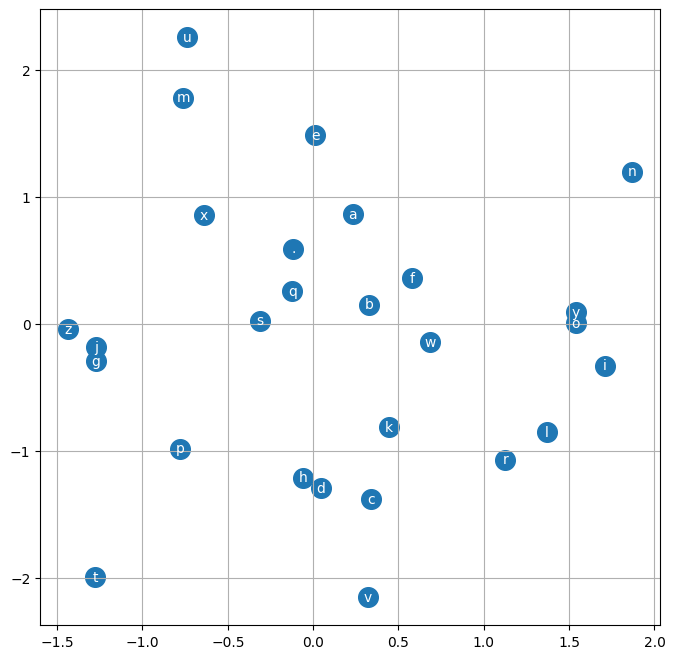

In [91]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i],
             ha="center", va="center", color='white')
plt.grid('minor')


In [101]:
# sampling from model
g = torch.Generator().manual_seed(1001+2)
for i in range(20):
	out = []
	context = [0] * block_size
	while True:
		emb = C[torch.tensor([context])]
		embcat = emb.view(1, -1)
		h_preact = embcat @ W1 #+ b1
		h_preact = bn_gain * (h_preact - bnmean_running) / bnstd_running + bn_bias # batch norm
		h = torch.tanh(h_preact)
		logits = h @ W2 + b2
		probs = F.softmax(logits, dim=1)
		ix = torch.multinomial(probs, num_samples=1, generator=g).item()
		context = context[1:] + [ix]
		out.append(ix)
		if ix == 0:
			break
	print(''.join(itos[i] for i in out))


kephael.
emeretzaviorand.
shahersin.
draget.
ram.
kik.
scarishem.
johani.
karo.
danyssa.
iva.
ter.
roanni.
dree.
drax.
brookellos.
brael.
akyani.
adlo.
sam.
